

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#D63B52;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>Playground Series - Season 3, Episode 9
        Tabular Regression with a Concrete Strength Dataset</b>
    </p>
</div>

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



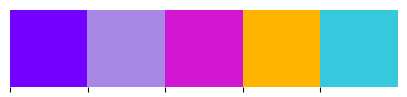

In [1]:
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from tqdm import tqdm

init_notebook_mode(connected=True)
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBRegressor

pd.set_option("display.max_columns", 50)
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category="FutureWarning")
# warnings.filterwarnings("ignore", category="DeprecationWarning")
# warnings.filterwarnings("ignore", category="UserWarning")

# Color Palette
custom_colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#7400ff;
       font-size:110%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <h1 style="padding: 10px;
          color:white;">
        Loading the files
    </h1>
</div>

In [2]:
train = pd.read_csv("train.csv").rename(columns=str.lower)
test = pd.read_csv("test.csv").rename(columns=str.lower)
ss = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,id,cementcomponent,blastfurnaceslag,flyashcomponent,watercomponent,superplasticizercomponent,coarseaggregatecomponent,fineaggregatecomponent,ageindays,strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [4]:
test.head()

,id,cementcomponent,blastfurnaceslag,flyashcomponent,watercomponent,superplasticizercomponent,coarseaggregatecomponent,fineaggregatecomponent,ageindays
0,5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56
1,5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7
2,5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28
3,5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
4,5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28


In [5]:
ss.head()

,id,Strength
0,5407,35.452
1,5408,35.452
2,5409,35.452
3,5410,35.452
4,5411,35.452


In [6]:
train["superplasticizercomponent"].value_counts()[:10]

0.0     3143
11.6     161
8.0      104
7.0      100
16.5      76
7.8       71
9.9       64
5.8       62
8.9       62
9.0       52
6.0       51
6.7       48
11.2      46
11.0      41
9.5       38
4.6       37
10.0      37
Name: superplasticizercomponent, dtype: int64

In [7]:
train.loc[:, "cementcomponent":"strength"].describe().T.style.bar(
    subset=["mean"], color="#206ff2"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
cementcomponent,5407.000000,299.168189,105.537682,102.000000,213.700000,297.200000,375.000000,540.000000
blastfurnaceslag,5407.000000,58.610579,83.417801,0.000000,0.000000,0.000000,122.600000,359.400000
flyashcomponent,5407.000000,31.872795,54.605003,0.000000,0.000000,0.000000,79.000000,200.100000
watercomponent,5407.000000,185.076235,18.517583,121.800000,175.100000,187.400000,192.000000,247.000000
superplasticizercomponent,5407.000000,4.108441,5.692296,0.000000,0.000000,0.000000,8.050000,32.200000
coarseaggregatecomponent,5407.000000,992.000718,77.148010,801.000000,938.200000,978.000000,1047.000000,1145.000000
fineaggregatecomponent,5407.000000,771.219974,78.725253,594.000000,734.300000,781.200000,821.000000,992.600000
ageindays,5407.000000,51.751618,70.006975,1.000000,7.000000,28.000000,56.000000,365.000000
strength,5407.000000,35.452071,16.401896,2.330000,23.640000,33.950000,45.850000,82.600000



<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#7400ff;
       font-size:110%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <h1 style="padding: 10px;
          color:white;">
Target distribution
    </h1>
</div>

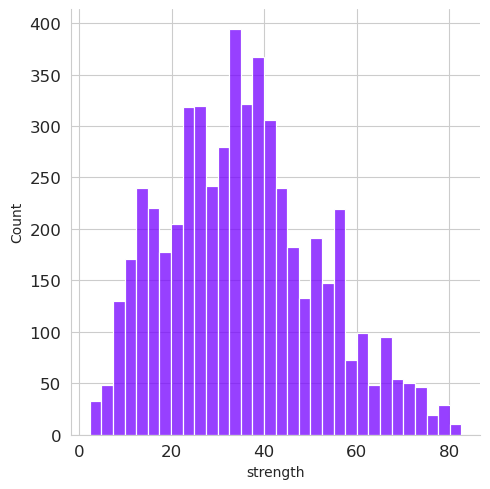

In [8]:
sns.displot(
    train["strength"],
    color=custom_colors[0],
)
plt.show()

It's nice that our target look more like a normal distribution.


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#7400ff;
       font-size:110%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <h1 style="padding: 10px;
          color:white;">
            Density plots of features
    </h1>
</div>

<Figure size 640x480 with 0 Axes>

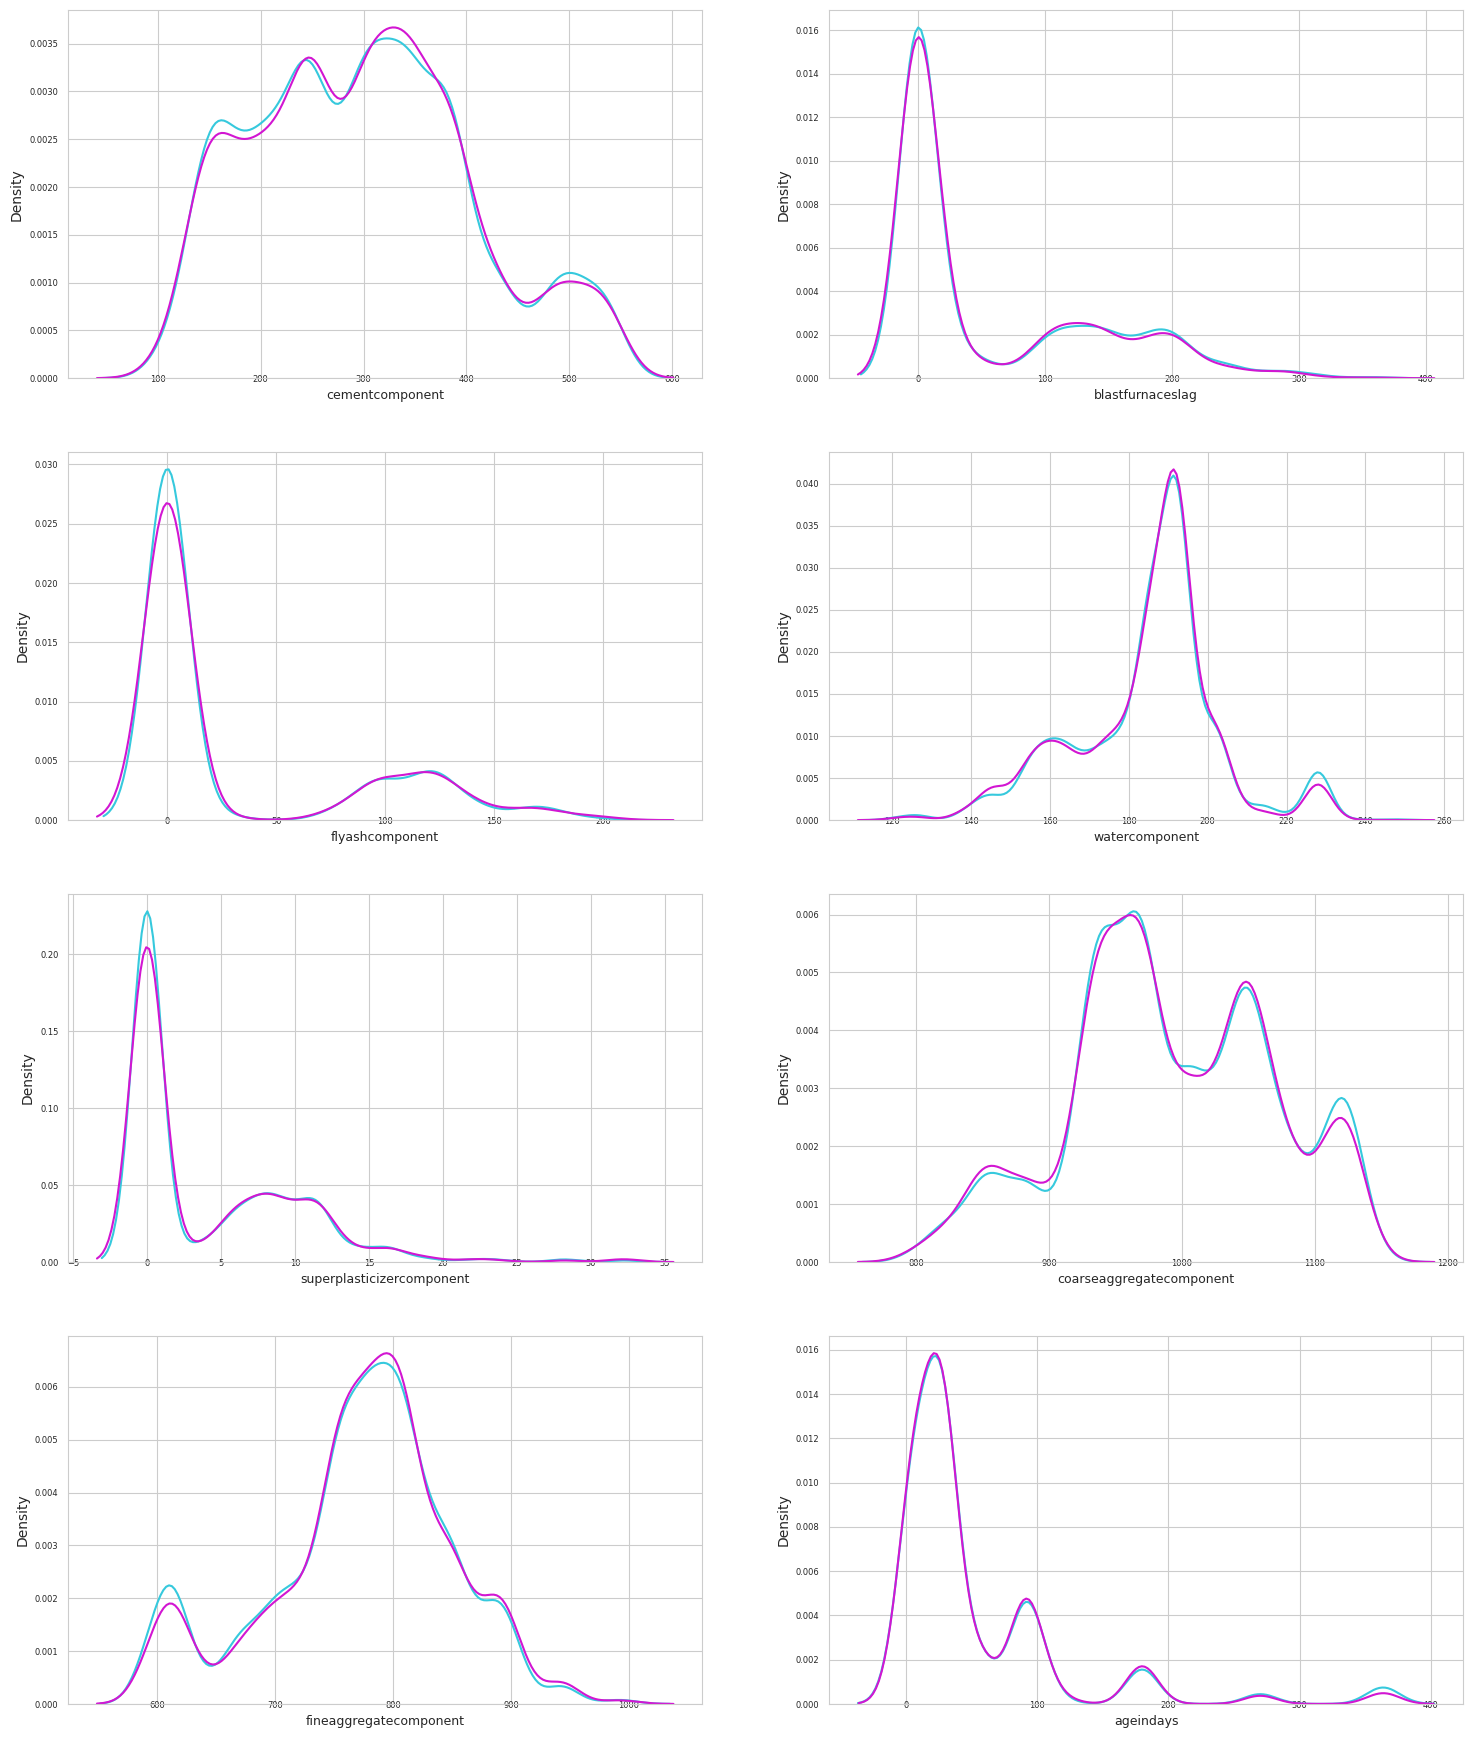

In [9]:
features = train.drop(["id", "strength"], axis=1).columns.values[0:10]
i = 0
sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(8, 8, figsize=(18, 22))

for feature in features:
    i += 1
    plt.subplot(4, 2, i)
    sns.distplot(train[feature], hist=False, label="train", color=custom_colors[4])
    sns.distplot(test[feature], hist=False, label="test", color=custom_colors[2])
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis="x", which="major", labelsize=6, pad=-6)
    plt.tick_params(axis="y", which="major", labelsize=6)
plt.show();

we can see that all of our features are not normally distributed so we might do something about this later or you can think of doing some tranformation 



<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#7400ff;
       font-size:110%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <h1 style="padding: 10px;
          color:white;">
            Heatmap correlation matrix
    </h1>
</div>

<AxesSubplot:>

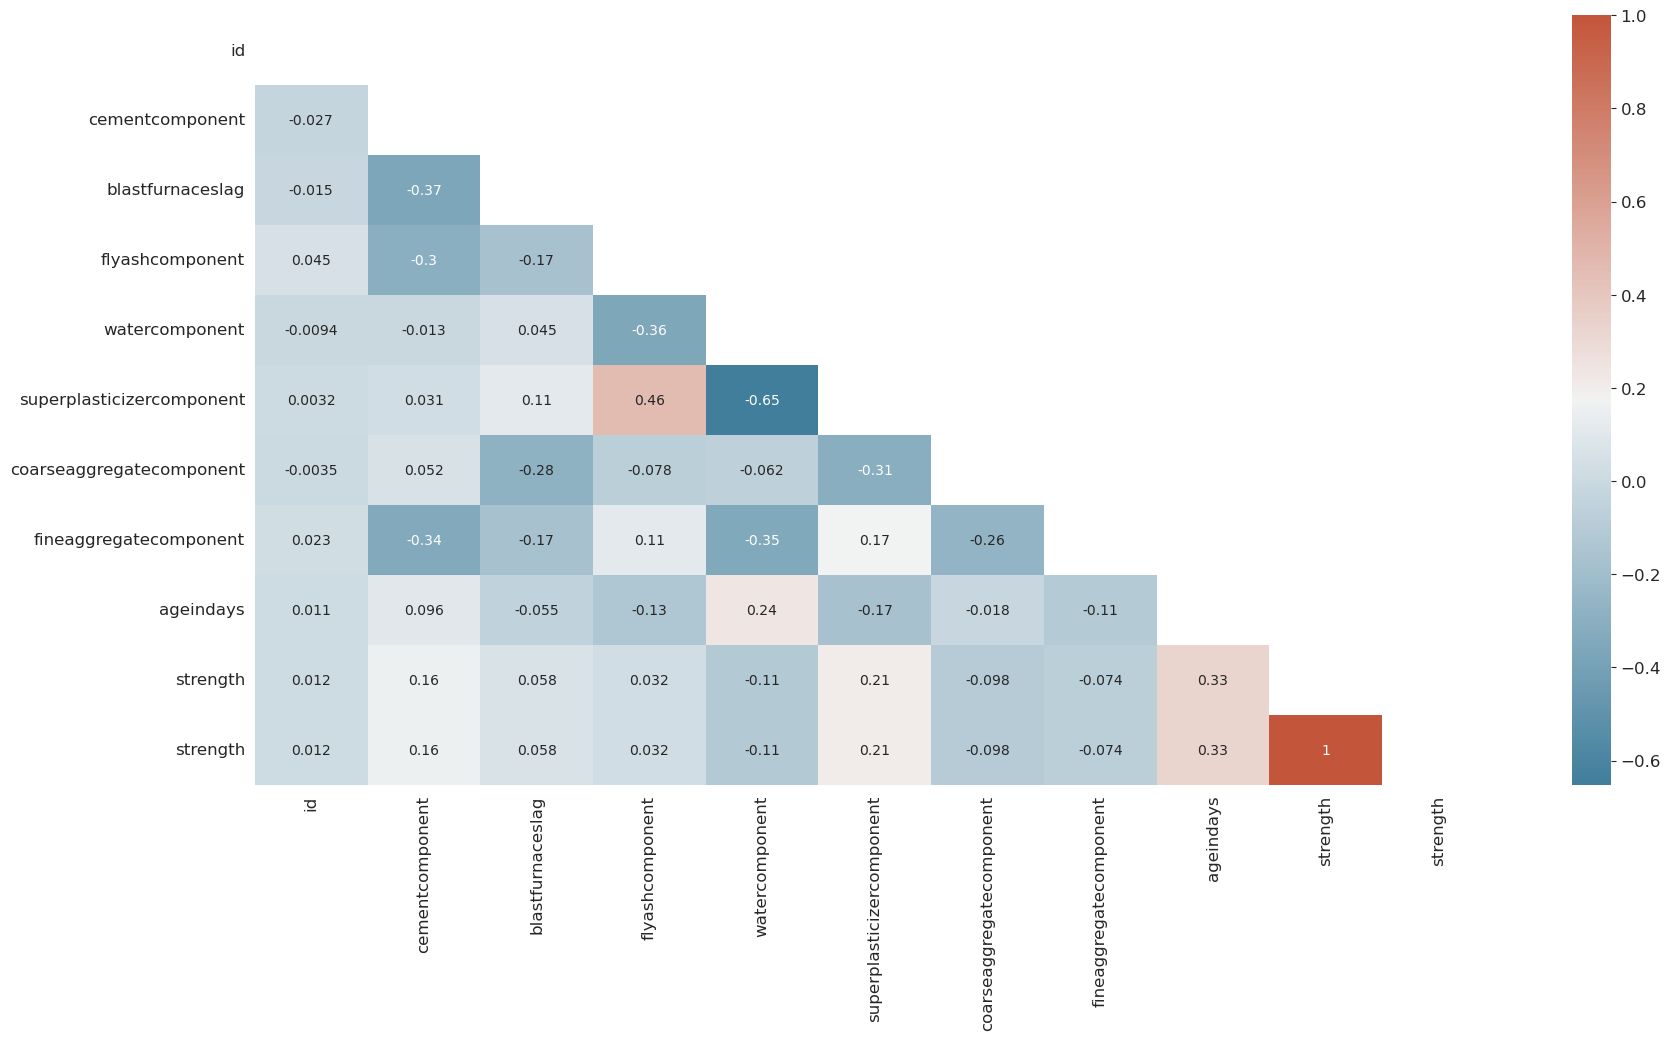

In [10]:
columns = train.columns[0:14].to_list()
columns.append("strength")

corr = train[columns].corr()
f, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    cmap=cmap,
)

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#AF65C1;
       font-size:150%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:white;">
        <b>5. Selecting the features and the target </b>
    </p>
</div>

In [11]:
X = train.drop(["id", "strength"], axis=1)
y = train["strength"]
test = test.drop("id", axis=1)

In [12]:
X.shape, test.shape

((5407, 8), (3605, 8))

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#AF65C1;
       font-size:150%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:white;">
        <b> Model Building with Catboost</b>
    </p>
</div>

In [13]:
params = {
    "objective": "tweedie",
    "metric": "rmse",
    "learning_rate": 0.09,
    "sub_feature": 0.8,
    "sub_row": 0.75,
    "bagging_freq": 1,
    "lambda_l2": 0.6,
    "num_iterations": 3000,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
}

In [14]:
cat_params = {
    "n_estimators": 510,
    "learning_rate": 0.01647528635187871,
    "depth": 5,
    "l2_leaf_reg": 1.4021175626682952e-05,
    "random_strength": 4.334702117773963e-09,
}

In [15]:
errcb = []
y_pred_totcb = []
fold = KFold(n_splits=5, shuffle=True, random_state=1)
i = 1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # m = LGBMRegressor(**params)
    m = CatBoostRegressor(**cat_params)
    # m = XGBRegressor()
    m.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=0,
        early_stopping_rounds=100,
    )
    preds = m.predict(X_test)
    print("err: ", metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test)
    y_pred_totcb.append(p)

err:  12.295535883180538
err:  11.734268818355757
err:  12.09258970689806
err:  11.803984259767624
err:  12.590991724783542


In [16]:
len(np.mean(y_pred_totcb, 0))

3605

In [17]:
ss.head()

,id,Strength
0,5407,35.452
1,5408,35.452
2,5409,35.452
3,5410,35.452
4,5411,35.452


In [18]:
ss["Strength"] = np.mean(y_pred_totcb, 0)
ss.head()

,id,Strength
0,5407,49.668537
1,5408,20.175183
2,5409,34.190566
3,5410,46.998114
4,5411,30.385057


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#AF65C1;
       font-size:150%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:white;">
        <b>Making submission file </b>
    </p>
</div>

In [19]:
ss.to_csv("./lgb.csv", index=False)
ss.head()

,id,Strength
0,5407,49.668537
1,5408,20.175183
2,5409,34.190566
3,5410,46.998114
4,5411,30.385057


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#a788e4;
       font-size:110%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        <b>Thank you for reading my notebook. If you have anyyyy suggestions, I will be glad. Please comment your thoughts below. Thank you again for sticking till the end. Take care! </b>
    </p>
</div>

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#ffb500;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>Please upvote if you like the notebook!</b>
    </p>
</div>

In [20]:
import optuna
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define objective function for Optuna to optimize
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-6, 1e2),
        "random_strength": trial.suggest_loguniform("random_strength", 1e-9, 10),
    }

    # Train CatBoostRegressor with given hyperparameters
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)

    # Evaluate model on validation set and return mean squared error
    y_pred = model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    return mse


# Define study and optimize hyperparameters using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print best hyperparameters and corresponding mean squared error
print("Best hyperparameters: ", study.best_params)
print("Best mean squared error: ", study.best_value)

[I 2023-03-02 14:48:03,503] A new study created in memory with name: no-name-67ce09f5-5d9e-4d13-9d38-69fb4bcc6b24
[I 2023-03-02 14:48:05,223] Trial 0 finished with value: 143.50114599031176 and parameters: {'n_estimators': 488, 'learning_rate': 0.035306928899480804, 'depth': 8, 'l2_leaf_reg': 0.08877627297077118, 'random_strength': 1.2922395348053326}. Best is trial 0 with value: 143.50114599031176.
[I 2023-03-02 14:48:06,749] Trial 1 finished with value: 157.59478070690588 and parameters: {'n_estimators': 233, 'learning_rate': 0.004422708630906432, 'depth': 9, 'l2_leaf_reg': 1.3487868996488161e-05, 'random_strength': 7.274281634359452e-06}. Best is trial 0 with value: 143.50114599031176.
[I 2023-03-02 14:48:06,991] Trial 2 finished with value: 138.0408549254777 and parameters: {'n_estimators': 187, 'learning_rate': 0.023295929312499634, 'depth': 5, 'l2_leaf_reg': 3.6788498475417655e-05, 'random_strength': 0.0007306655100667801}. Best is trial 2 with value: 138.0408549254777.
[I 2023-0

Best hyperparameters:  {'n_estimators': 539, 'learning_rate': 0.018099819322563694, 'depth': 4, 'l2_leaf_reg': 4.32108828610904e-06, 'random_strength': 3.118155880306416e-06}
Best mean squared error:  137.5778063666806
